In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam

from keras.layers import RandomRotation, RandomZoom, RandomFlip

from keras.applications.vgg16 import VGG16,preprocess_input
 

2023-12-05 12:36:18.491501: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 12:36:18.528058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 12:36:18.530229: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 12:36:19.400541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = 'Dataset'

# Set the base directory for the split images
output_folder = 'Splitted'

# Set the ratio of images for each split
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))

Copying files: 0 files [00:00, ? files/s]

Copying files: 6400 files [00:03, 1720.68 files/s]


In [5]:
from keras.preprocessing.image import ImageDataGenerator


BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )
       
validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = 'Splitted/train'
validation_dir = 'Splitted/val'
test_dir = 'Splitted/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')


# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 10

Found 5119 images belonging to 4 classes.
Found 639 images belonging to 4 classes.
Found 642 images belonging to 4 classes.


In [6]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


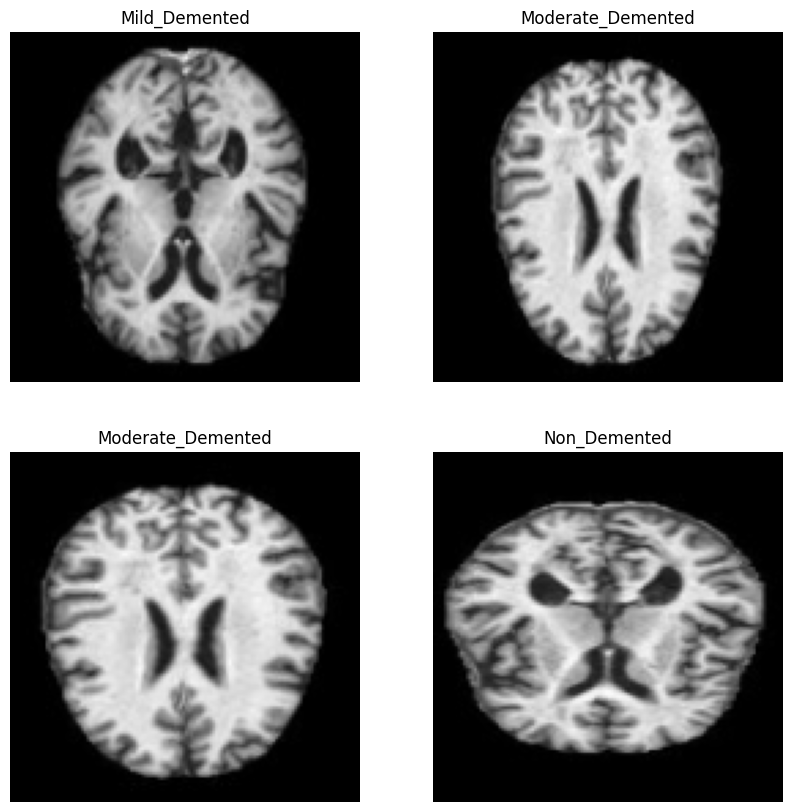

In [7]:
# show an image for each class in a grid of 2*2
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(train_generator[0][0][i+j])
        ax[i, j].set_title(class_names[i+j])
        ax[i, j].axis('off')
plt.show()


In [8]:
#preprocessing for rotation and zoom
def data_augmentar():
   
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [9]:
data_augmentation = data_augmentar()

2023-12-05 12:36:36.308478: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 12:36:36.310010: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


IMBALANCED DATA !

In [10]:
## Calculate number of samples in each class.
input_folder = 'Dataset'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

print(class_counts)

{'Mild_Demented': 896, 'Moderate_Demented': 64, 'Non_Demented': 3200, 'Very_Mild_Demented': 2240}


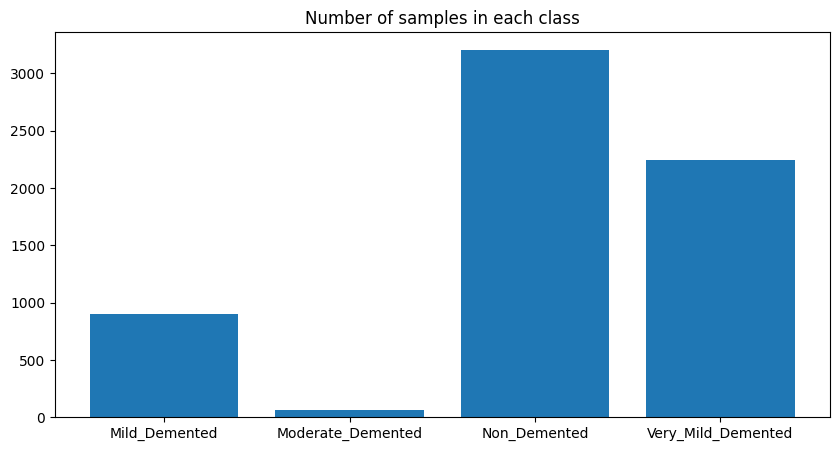

In [11]:
# plot the number of samples in each class
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of samples in each class')
plt.show()


In [12]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


In [13]:
print("shape of train generator",train_generator[0][0].shape)


shape of train generator (64, 128, 128, 3)


VGG16

In [27]:
base_model_3 = VGG16(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")
for layer in base_model_3.layers:
  layer.trainable= False

Copying files: 0 files [09:29, ? files/s]
Copying files: 0 files [09:07, ? files/s]


In [1]:
global_average_layer = GlobalAveragePooling2D()

prediction_layer = Dense(4,activation='softmax')

model3 = tf.keras.Sequential([
  base_model_3, 
  global_average_layer,
  BatchNormalization(),  
  Dense(2048, activation='relu'),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(64, activation='relu'),
  prediction_layer
])

NameError: name 'GlobalAveragePooling2D' is not defined

In [32]:
model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model3.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)

Epoch 1/10


2023-11-25 15:36:02.128944: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-11-25 15:36:02.188943: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


 1/80 [..............................] - ETA: 2:59 - loss: 1.5198 - accuracy: 0.0000e+00 - auc: 0.3953 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-11-25 15:36:03.375127: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-11-25 15:36:03.416670: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


 2/80 [..............................] - ETA: 1:35 - loss: 1.3358 - accuracy: 0.2188 - auc: 0.6127 - precision: 0.5806 - recall: 0.1406            

2023-11-25 15:36:04.604519: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


80/80 [==============================] - 115s 1s/step - loss: 0.9462 - accuracy: 0.5335 - auc: 0.8279 - precision: 0.6305 - recall: 0.3831 - val_loss: 1.0161 - val_accuracy: 0.5008 - val_auc: 0.8286 - val_precision: 0.7788 - val_recall: 0.2535
Epoch 2/10
80/80 [==============================] - 114s 1s/step - loss: 0.8026 - accuracy: 0.6320 - auc: 0.8802 - precision: 0.6976 - recall: 0.5228 - val_loss: 0.9914 - val_accuracy: 0.5399 - val_auc: 0.8456 - val_precision: 0.8271 - val_recall: 0.2770
Epoch 3/10
80/80 [==============================] - 115s 1s/step - loss: 0.7007 - accuracy: 0.6892 - auc: 0.9101 - precision: 0.7363 - recall: 0.6197 - val_loss: 0.9037 - val_accuracy: 0.6307 - val_auc: 0.8744 - val_precision: 0.7348 - val_recall: 0.3599
Epoch 4/10
80/80 [==============================] - 153s 2s/step - loss: 0.6329 - accuracy: 0.7242 - auc: 0.9273 - precision: 0.7617 - recall: 0.6726 - val_loss: 0.8201 - val_accuracy: 0.6823 - val_auc: 0.9049 - val_precision: 0.8167 - val_recall

In [33]:
# save the model
model3.save('model_VGG.h5')

/home/felicien/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')

11/11 [==============================] - 12s 1s/step - loss: 0.3769 - accuracy: 0.8364 - auc: 0.9738 - precision: 0.8521 - recall: 0.8255
Test Loss = 0.3769453763961792
Test Accuracy = 0.836448609828949
Test AUC = 0.973785936832428
Test Precision = 0.852090060710907
Test Recall = 0.8255451917648315


1/1 [==============================] - 0s 39ms/step


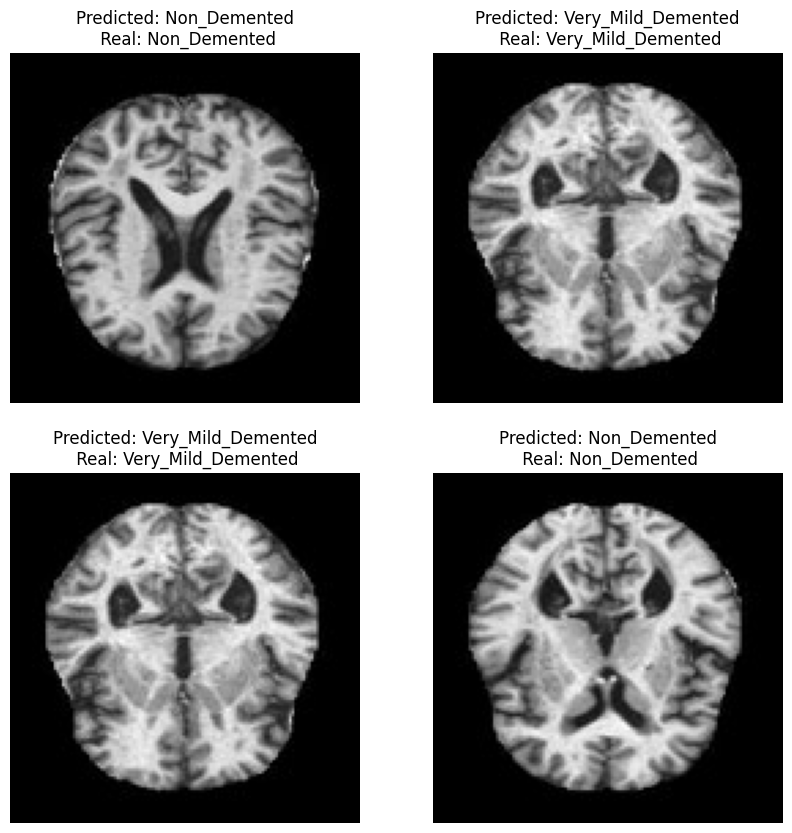

In [39]:
# Plot some images and predictions vs real value for the test set
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        ax[i, j].imshow(test_generator[0][0][i+j])
        ax[i, j].set_title(f'Predicted: {class_names[np.argmax(model3.predict(test_generator[0][0][i+j].reshape(1,128,128,3)))]}\n Real: {class_names[np.argmax(test_generator[0][1][i+j])]}')
        ax[i, j].axis('off')
plt.show()


1/1 [==============================] - 0s 137ms/step
Predicted class: Mild_Demented with probability 0.9070460796356201


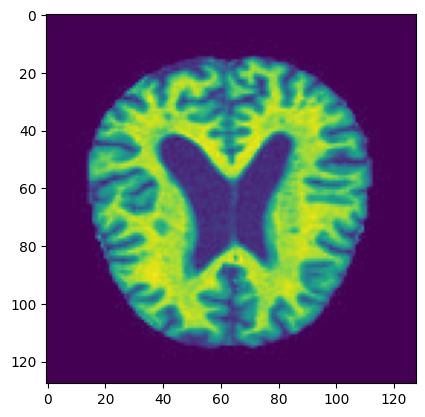

In [54]:
# take picture from : Splitted/test/Mild_Demented/mild_8.jpg which is Mild_Demented
img = skimage.io.imread('Splitted/test/Mild_Demented/mild_8.jpg')
plt.imshow(img)

# prepare the image for the VGG model
img = skimage.transform.resize(img, (128, 128, 3))
img = np.expand_dims(img, axis=0)

from keras.models import load_model

model_test = load_model("model_VGG.h5")

# predict the class
prediction = model_test.predict(img)
print(f'Predicted class: {class_names[np.argmax(prediction)]} with probability {np.max(prediction)}')




In [60]:
#take all the images from the test set moderate_demented and check the accuracy of the prediction
path = 'Splitted/test/Moderate_Demented/'
files = os.listdir(path)
files.sort()
files = files[0:7]
accuracy_Moderate_Demented= 0
for file in files:
    img = skimage.io.imread(path+file)
    img = skimage.transform.resize(img, (128, 128, 3))
    img = np.expand_dims(img, axis=0)
    prediction = model_test.predict(img)
    print(f'Predicted class: {class_names[np.argmax(prediction)]} with probability {np.max(prediction)}')
    print(f'Real class: Moderate_Demented')
    if class_names[np.argmax(prediction)] == "Moderate_Demented":
        accuracy_Moderate_Demented += 1


#take all the images from the test set mild_demented and check the accuracy of the prediction
path = 'Splitted/test/Mild_Demented/'
files = os.listdir(path)
files.sort()
files = files[0:20]
accuracy_Mild_Demented = 0
for file in files:
    img = skimage.io.imread(path+file)
    img = skimage.transform.resize(img, (128, 128, 3))
    img = np.expand_dims(img, axis=0)
    prediction = model_test.predict(img)
    print(f'Predicted class: {class_names[np.argmax(prediction)]} with probability {np.max(prediction)}')
    print(f'Real class: Mild_Demented')
    if class_names[np.argmax(prediction)] == "Mild_Demented":
        accuracy_Mild_Demented += 1


#take all the images from the test set non_demented and check the accuracy of the prediction

path = 'Splitted/test/Non_Demented/'
files = os.listdir(path)
files.sort()
files = files[0:20]
accuracy_Non_Demented = 0
for file in files:
    img = skimage.io.imread(path+file)
    img = skimage.transform.resize(img, (128, 128, 3))
    img = np.expand_dims(img, axis=0)
    prediction = model_test.predict(img)
    print(f'Predicted class: {class_names[np.argmax(prediction)]} with probability {np.max(prediction)}')
    print(f'Real class: Non_Demented')
    if class_names[np.argmax(prediction)] == "Non_Demented":
        accuracy_Non_Demented += 1

# take all the images from the test set very_mild_demented and check the accuracy of the prediction
path = 'Splitted/test/Very_Mild_Demented/'
files = os.listdir(path)
files.sort()
files = files[0:20]
accuracy_Very_Mild_Demented = 0
for file in files:
    img = skimage.io.imread(path+file)
    img = skimage.transform.resize(img, (128, 128, 3))
    img = np.expand_dims(img, axis=0)
    prediction = model_test.predict(img)
    print(f'Predicted class: {class_names[np.argmax(prediction)]} with probability {np.max(prediction)}')
    print(f'Real class: Very_Mild_Demented')
    if class_names[np.argmax(prediction)] == "Very_Mild_Demented":
        accuracy_Very_Mild_Demented += 1
        

print(f'Accuracy for Very_Mild_Demented: {accuracy_Very_Mild_Demented/len(files)}')
print(f'Accuracy for Non_Demented: {accuracy_Non_Demented/len(files)}')
print(f'Accuracy for Mild_Demented: {accuracy_Mild_Demented/len(files)}')
print(f'Accuracy for Moderate_Demented: {accuracy_Moderate_Demented/len(files)}')




1/1 [==============================] - 0s 37ms/step
Predicted class: Moderate_Demented with probability 0.9569922089576721
Real class: Moderate_Demented
1/1 [==============================] - 0s 38ms/step
Predicted class: Moderate_Demented with probability 0.8196415305137634
Real class: Moderate_Demented
1/1 [==============================] - 0s 46ms/step
Predicted class: Moderate_Demented with probability 0.9875553250312805
Real class: Moderate_Demented
1/1 [==============================] - 0s 51ms/step
Predicted class: Non_Demented with probability 0.5442042350769043
Real class: Moderate_Demented
1/1 [==============================] - 0s 41ms/step
Predicted class: Non_Demented with probability 0.5116908550262451
Real class: Moderate_Demented
1/1 [==============================] - 0s 42ms/step
Predicted class: Moderate_Demented with probability 0.9943565726280212
Real class: Moderate_Demented
1/1 [==============================] - 0s 41ms/step
Predicted class: Non_Demented with proba